# LangGraph Building LLM Applications

LangGraph is a framework for building agent-based and multi-agent applications, providing a graph-based approach to knowledge representation. This structure offers greater precision and control over agent workflows, distinguishing it from LangChain, which follows a more sequential pipeline model.


- Enables agents to automate complex tasks efficiently.

- Supports multi-agent collaboration with structured execution paths.

- Offers enhanced workflow customization through graph-based representations.


In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
gpt4o_chat = ChatOpenAI(model="gpt-4o", temperature=0)
gpt35_chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

In [5]:
from langchain_core.messages import HumanMessage

# Create a message
msg = HumanMessage(content="Hello world", name="Lance")

# Message list
messages = [msg]

# Invoke the model with a list of messages 
gpt4o_chat.invoke(messages)

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-4e52fb9e-5dfc-4e7f-b44c-70e56b6b7c5a-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Search Tools

Tavily is a search engine optimized for LLMs and Retrieval-Augmented Generation (RAG). It enhances knowledge retrieval by providing relevant, structured, and efficient search results tailored for AI applications.

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("Robot Guitars in the World")
print(search_docs)

[{'url': 'https://epiphonetalk.com/threads/2007-gibson-proudly-presents-the-robot-guitar.1673/', 'content': "... Robot Guitar—the world's first guitar with robotic technology. Since the dawn of the instrument, musicians have come to accept the guitar's"}, {'url': 'https://en.wikipedia.org/wiki/Gibson_Robot_Guitar', 'content': 'The Gibson Robot Guitar (aka GOR) is a limited-edition self-tuning Gibson guitar, typically a Les Paul.'}, {'url': 'https://www.nbcnews.com/id/wbna21791941', 'content': 'Gibson said the robot guitar is the biggest advance in electric guitar design in more than 70 years. "It\'s very addictive," Juszkiewicz said.'}]



## Simple Graph

### **State**
- Defines the **input schema** for nodes and edges in the graph.
- Typically implemented using `TypedDict` from the `typing` module for structure enforcement.

### **Nodes**
- Represent **Python functions** that modify the graph state.
- Each node operates on `graph_state`, updating or transforming its values.

### **Edges**
- **Standard edges** → Connect nodes sequentially.
- **Conditional edges** → Route execution based on defined conditions, enabling dynamic flows.
LangGraph leverages these components to create **structured, adaptable workflows** for LLM applications.



In [ ]:
# define state
import random
from typing_extensions import TypedDict
from typing import Literal

class State(TypedDict):
    graph_state: str

# define 3 nodes
def node1(state: State):
    print("node1")
    state["graph_state"] = "I am"
    return state

def node2(state: State):
    print("node2")
    state["graph_state"] = "happy"
    return state

def node3(state: State):
    print("node3")
    state["graph_state"] = "sad"
    return state

# after 1st node, decide on the next node to visit 2 or 3
def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # user_input = state['graph_state'] 
    if random.random() < 0.5: 
        return "node_2"
    
    return "node_3"

### Graph Construction

Let's make a graph with nodes and edges. 
- The `StateGraph` class is used to construct the graph with `State`.
- then we add nodes and edges to the graph as `.add_node` and `.add_edge` methods.
  - Conditional edges are added with `.add_conditional_edge` method.

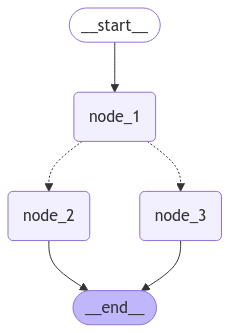

In [10]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# graph build
builder = StateGraph(State)
builder.add_node("node_1", node1)
builder.add_node("node_2", node2)
builder.add_node("node_3", node3)

# logic 
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

- The `START` is a special node that is the entry point of the graph, let's us input the initial state.

### Graph Invocation

The graph is implemented as a `runnable` protocol. This means that the graph provides a standard way to execute langchain components.

- `invoke` method is used to run the graph.


In [7]:
graph.invoke({"graph_state": "Hi, this is Lance"})

node1
node3


{'graph_state': 'sad'}

## Chaining Nodes

### **Chat Messages**

- Messages have a **role**, **content**, and **response metadata**:
  - **Role** → Specifies the message source (`"user"`, `"assistant"`, `"system"`, `"tool"`).
  - **Content** → The actual message, which can be:
    - A **string** (most common format).
    - A **list of dictionaries** (for multimodal inputs).
  - **Response Metadata** → Stores additional details like log-probabilities or token usage.

### **Chat Models**

- Represents different LLMs that process chat messages.

### **Binding Tools to Chat Models**

- **Tools** are utilities designed to be invoked by the model, ensuring input compatibility.
- Each tool consists of:
  - **`name`** → Identifier for the tool.
  - **`description`** → Brief overview of its functionality.
  - **`JSON schema`** → Defines the input/output format.
  - **`function`** → Implements the tool's logic (can be async if needed).

### **Executing Tool Calls in Graph Nodes**

- Tools can be executed within **graph nodes**, enabling dynamic interactions within LangGraph workflows.





## Messages

- Chat models can use `messages` which capture different roles within a conversation.
- LangChain supports various types including `HumanMessage`, `AIMessage`, `SystemMessage`, `ToolMessage`, etc.
- Each message has: `content`, `role`, `response_metadata`.
  
  


In [ ]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(
    content=f"So you said you were researching ocean mammals?", 
    name="Model")
]
messages.append(
    HumanMessage(content=f"Yes, that's right.",name="Lance")
)

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.


## Chat Models

Like OpenAI can use a sequence of messages as input and support message types like `HumanMessage`, `AIMessage`, `SystemMessage`, `ToolMessage`, etc.

In [14]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [10]:
print(result.content)
print("metadata")
print(result.response_metadata)

print("Token costs")
print(result.response_metadata['token_usage'])

That sounds fascinating! Ocean mammals are such diverse and intriguing creatures. Are you focusing on a specific species or aspect of ocean mammals, or are you exploring them more broadly?
metadata
{'token_usage': {'completion_tokens': 34, 'prompt_tokens': 29, 'total_tokens': 63, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'stop', 'logprobs': None}


## Tools

Many providers support tool calling, which is a way to call a tool from a model. To do this the model is made aware of the tool's name and the tool's input schema. So it generates the payload for the tool call and sends it to the tool.

<image src="https://camo.githubusercontent.com/9ccbea2be12f1cb8a31c62e10a2360c30f35879c7860d66626d6aac58f648e9d/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261623038646331633137613761353766393936305f636861696e322e706e67">

In [15]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [18]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 20 multiplied by 15", name="Lance")])

print(tool_call.additional_kwargs)
tool_call.pretty_print()

{'tool_calls': [{'id': 'call_M17fIOw2Us9T4hOy3n26Z2io', 'function': {'arguments': '{"a":20,"b":15}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}
================================== Ai Message ==================================
Tool Calls:
  multiply (call_M17fIOw2Us9T4hOy3n26Z2io)
 Call ID: call_M17fIOw2Us9T4hOy3n26Z2io
  Args:
    a: 20
    b: 15


## `MessagesState`

Let's see how to use messages in our graph. 

`MessagesState`:
- has `messages` key
- a list of `AnyMessages` 
- it uses the `add_message` reducer. 

In [ ]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    pass

In [ ]:
from langgraph.graph.message import add_messages
# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
]

# New message to add
new_message = AIMessage(
    content="Sure, I can help with that. What specifically are you interested in?", 
    name="Model"
)

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='589e9b84-1f68-428c-b693-db365af0f537'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='70feec8b-20e5-48b7-bf76-4135f5906330'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='6d1c0035-1248-493c-a4bc-813ee06576bd')]

In [15]:
state = MessagesState()

## Graph

Let's look at it a flow from input to output. In this case:

- Return a natural language response. 
- Or a tool call.


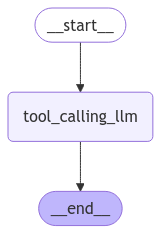

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState, add_messages


# Step 1: Define the `MessagesState` class if it's not already properly defined
class MessagesState(MessagesState):
    pass


# Step 2: Define the function `tool_calling_llm` to handle both `MessagesState` and `dict` inputs
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}


# Step 3: Build the state graph with `StateGraph`
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)  
# add edges
builder.add_edge(START, "tool_calling_llm")            
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()  # Compile the graph

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
# Step 4: Define initial input messages
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# Step 5: Create a `MessagesState` object for the input
input_state = MessagesState(messages=initial_messages)


# Step 6: Invoke the graph
print("Invoking the graph...")
try:
    print(input_state)
    result = graph.invoke(input_state)
    print("Graph Result:", result)
except Exception as e:
    print("Error while invoking the graph:", e)

Invoking the graph...
{'messages': [AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model'), HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance')]}
Graph Result: {'messages': [AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='baf4f58e-5d33-482f-b416-7f289b65a67e'), HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='ea7ca5f6-69e0-46b0-b8f6-f82c911ea861'), AIMessage(content="Marine biology is the scientific study of organisms in the ocean or other marine or brackish bodies of water. It covers a wide range of topics, including the study of marine organisms, their behaviors, and interactions with the environment. Here are some key points about marine biology:\n\n1. **Diversity of Life**: Marine biology encompasses the stud

In [18]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_rzcl8HR9Anu91JP35CXxLRwg)
 Call ID: call_rzcl8HR9Anu91JP35CXxLRwg
  Args:
    a: 2
    b: 3


## Router via `ToolNode` and `tools_condition`

We can think of the Graph as a router. Chat model routes between response or tool based upon user input.  Let's use the graph to route between the two.

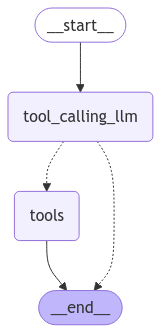

In [20]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([multiply])


# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

This tool so far, decides to make a tool or not basd on the user input. 
- We use a conditional edge to decide between the two.

 ## Agent

- `act` - let the model call the specific tool.
- `observe` - pass tool output back to the model.
- `reason` - let the model reason about the tool output and decide what to do next, call another tool or return a response.
  

  <image src="https://camo.githubusercontent.com/f5f9c339b6e85deb9f01b26585c2bbd5cf706cb185dea5606fd02ff778777bca/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261633062346132633165356530326633653738625f6167656e74322e706e67">

  

We define some tool functions and the model needs to call them at his own discretion.

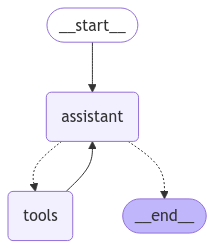

In [12]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from IPython.display import Image, display


llm = ChatOpenAI(model="gpt-4o")

# Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b 

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:

        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
# parallel tool calling is set to False to avoid the tool calls being made in parallel - only once
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Agent Memory - specifying a Thread


- We can continue were we left off by specifying the thread id.
- We can persist the Chat afte runtime ends, by specifying the `MemorySaver` in the graph.

In [15]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()


================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_nvZlAlC9Wy7Vgis5Jzkijhtw)
 Call ID: call_nvZlAlC9Wy7Vgis5Jzkijhtw
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.



We built up to an agent with memory:

- act - let the model call specific tools
- observe - pass the tool output back to the model
- reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
- persist state - use an in memory checkpointer to support long-running conversations with interruptions

<image src="https://camo.githubusercontent.com/61548a99125455bc9096962c25340dd2c94add0d5b5f2ee0562017ae816a0160/68747470733a2f2f63646e2e70726f642e776562736974652d66696c65732e636f6d2f3635623863643732383335636565616364343434396135332f3636646261643466353330383065363830326365633334645f6465706c6f796d656e74253230312e706e67">

## LangGraph SDK Trigger 

In [ ]:
from langgraph_sdk import get_client
# Replace this with the URL of your own deployed graph
URL = "http://localhost:60651"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [22]:
assistants

[{'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'created_at': '2024-11-22T17:58:41.032818+00:00',
  'updated_at': '2024-11-22T17:58:41.032818+00:00',
  'config': {},
  'metadata': {'created_by': 'system'},
  'version': 1,
  'name': 'agent'}]

- The `thread_id`
- The `graph_id`
- The `input`
- The `stream_mode`



In [23]:
# We create a thread for tracking the state of our run
thread = await client.threads.create()

In [ ]:
from langchain_core.messages import HumanMessage

# Input
input = {"messages": [HumanMessage(content="What is one name of a website in AI now")]}

# Stream
async for chunk in client.runs.stream(
        thread['thread_id'],
        "agent",
        input=input,
        stream_mode="values",
    ):
    if chunk.data and chunk.event != "metadata":
        print(chunk.data['messages'][-1])

{'content': 'What is one name of a website in AI now', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'fd04cabd-5c88-453f-8f71-f9b402629730', 'example': False}
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_6DNVvmmfCbiHbGDec3paARQE', 'function': {'arguments': '{"query":"AI websites"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 19, 'prompt_tokens': 560, 'total_tokens': 579, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-a8bcafe4-c5fd-47cc-83eb-4824631abe

## Schemas

- `StateGraph` defines types of data the graphs will use.
- We can use `TypedDict` from `typing` module to define the schema.

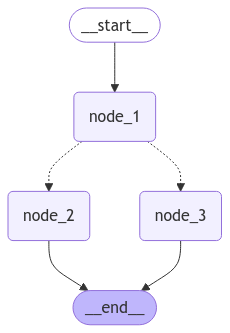

In [ ]:
from typing_extensions import TypedDict
from typing import Literal
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy", "sad"]

# This would also work... 
# from dataclasses import dataclass
# @dataclass
# class DataClassState:
#     name: str
#     mood: Literal["happy", "sad"]


def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:

    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [2]:
graph.invoke({"name":"Lance"})

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

Notice, that the state is altered by the graph execution. Different parts of the graph could populate the state with different data.

## State with Validator

Validation Error: 1 validation error for PydanticState
mood
  Value error, Each mood must be either 'happy' or 'sad' [type=value_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/value_error


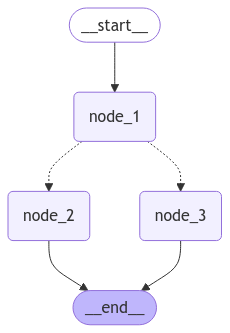

In [ ]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

# showing validation error
try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)
    
# nodes
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# edges / logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# compile
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Reducers

They specify how to update the state keys. When a node branches into more. Each node is in parallel, and can update the state in different way. Which is why we need reducers to specify how to update the state keys.

We can use  `Annotated` type to specify a reducer.

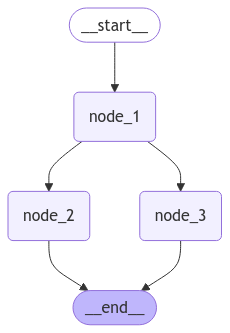

In [4]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.


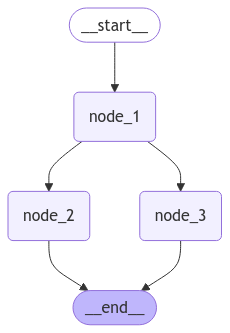

In [7]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Node 2 and 3 will be visited in parallel 
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

## Custom Reducer

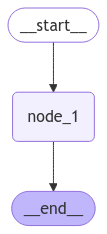

TypeError occurred: can only concatenate list (not "NoneType") to list


In [12]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]
    

def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

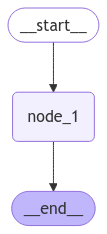

---Node 1---
{'foo': [2]}


In [14]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
     print(f"TypeError occurred: {e}")

## Messages

The most common state used is `MessageState` so use it to define the schema.


In [ ]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str

## Rewriting

If we pass a message with the same `id` as an existing one in our `messages` it will be overwritten.

## Removal

from langchain_core.messages import RemoveMessage

# Message list
```python
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))
```

# Isolate messages to delete
```python
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)
add_messages(messages , delete_messages)
```

## Multiple Schemas

- Typically graph nodes communicate with a single schema. 
- Sometimes you need more control: *internal nodes pass information that is not required in the graph input or output*.

## Input / Output Schema

- Often you want an internal schema that contains all keys relevant to the graph operations 


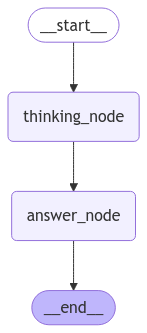

{'answer': 'bye Lance'}

In [ ]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

class OverallState(TypedDict):
    question: str
    answer: str
    notes: str

def thinking_node(state: InputState):
    return {
        "notes": "... his is name is Lance"
        }

def answer_node(state: OverallState) -> OutputState:
    return {"answer": "bye Lance"}
ß

graph = StateGraph(OverallState, input=InputState, output=OutputState)
graph.add_node("thinking_node", thinking_node)
graph.add_node("answer_node", answer_node)

graph.add_edge(START, "thinking_node")
graph.add_edge("thinking_node", "answer_node")
graph.add_edge("answer_node", END)

graph = graph.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"question":"hi"})

## Filtering messages

We will build a chatbot with long term memory. 

In [18]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Chat Model

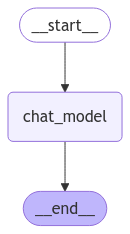

In [16]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(
    MessagesState
)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
output = graph.invoke({'messages': [
    HumanMessage(content="What is the capital of France?")
]})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the capital of France?
================================== Ai Message ==================================

The capital of France is Paris.


## Chat Bot with Reducer

Long running conversations result in high token usage because we pass a growing list of messages to the model.

- Let's use `RemoveMessage` and `add_messages` to remove all but the last 2 messages

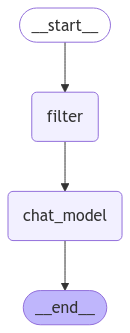

In [ ]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Other option would be to save `messages` yourself but only let the LLM see `messages[-1]`

```python
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

output = graph.invoke({"messages": messages})

messages.append(output['messages'][-1])

messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

for m in messages:
    m.pretty_print()
```

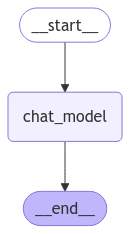

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

If you're interested in expanding your knowledge beyond whales, there are many fascinating topics in the realm of marine life and the ocean environment. Here are a few suggestions:

1. **Dolphins and Porpoises**: Learn about these intelligent cetaceans known for their social behavior and communication skills.

2. **Sharks**: Explore the diverse species of sharks, their roles in marine ecosystems, and efforts to conserve them.

3. **Seahorses and Pipefish**: Discover the unique reproductive roles these fish play, with males carrying the offspring.

4. **Coral Reefs**: Study the biodiversity of coral ecosystems and

In [ ]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

output = graph.invoke({"messages": messages})

messages.append(output['messages'][-1])

messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

for m in messages:
    m.pretty_print()

In [28]:
len(messages)

4

## Trimming Messages

Another option would be to trim messages up to a certain number of tokens. 

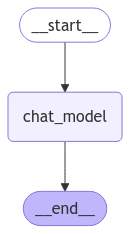

In [55]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node_trim(state: MessagesState) -> MessagesState:
    messages = trim_messages(
            state["messages"],
            max_tokens=30,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node_trim)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:

messages = list()
messages.append(AIMessage(f"Hello, I am a chatbot. I can help you with your questions. What would you like to know?", name="Model"))
messages.append(AIMessage(f"Hello, I am a chatbot. I can help you with your questions. What would you like to know?", name="Model"))
messages.append(AIMessage(f"Hello, I am a chatbot. I can help you with your questions. What would you like to know?", name="Model"))
messages.append(AIMessage(f"....asdfasjdfa;lksdjfa;lksdjf;alskdjfa;lskdjfa;lskdjfa;lskdjfa;slkdjfa;lskdjfa;lskjdf;alskjf;laskjdfl;askjdlasdjfalskdjfa;lksjdf;laksjdf;laksjdf;laskjdf;laksjdf;alksjdf;alksjdf;alskjdf;alskjdf;alskjdf;laskjf;laksjd;fklj", name="Model"))
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

# Invoke, using message trimming in the chat_model_node 
messages = graph.invoke({'messages': messages})

In [57]:
print(messages)

[AIMessage(content='....asdfasjdfa;lksdjfa;lksdjf;alskdjfa;lskdjfa;lskdjfa;lskdjfa;slkdjfa;lskdjfa;lskjdf;alskjf;laskjdfl;askjdlasdjfalskdjfa;lksjdf;laksjdf;laksjdf;laskjdf;laksjdf;alksjdf;alksjdf;alskjdf;alskjdf;alskjdf;laskjf;laksjd;fklj', additional_kwargs={}, response_metadata={}, name='Model', id='244d5c76-b7cd-4dcf-b3f7-a8abd284adf9'), HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance', id='62884a6e-f93d-4656-adf4-5364b3bb9556')]


## Running Summary Chatbot



In [61]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import END

model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str
    # messages is already defined in MessagesState


# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}


def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

State is transient, limited to a single graph execution.
But the graph has memory. You can use a checkpointer to automatically save and load the state between executions.

- We do this using `MemorySaver`
- This checkpointer saves each step as a checkpoint. These checkpoints can be grouped into a thread of the conversation.

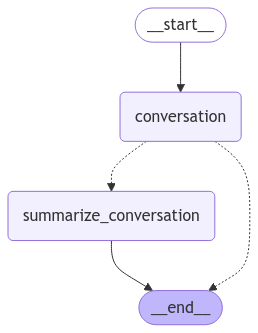

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you further?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Do you have a favorite player or a memorable game that you particularly enjoyed?


In [64]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

As of my last update, Nick Bosa signed a contract extension with the San Francisco 49ers in September 2023, making him one of the highest-paid defensive players in NFL history. His contract was a five-year deal worth $170 million, with $122.5 million guaranteed. This deal set a new benchmark for defensive players in terms of average annual salary. Bosa's impact on the field has been significant, and his contract reflects his value to the team.


In [65]:
graph.get_state(config).values.get("summary","")

'Lance introduced himself and expressed his support for the San Francisco 49ers, mentioning his liking for player Nick Bosa. The conversation highlighted that Nick Bosa became one of the highest-paid defensive players in NFL history with a five-year, $170 million contract extension with the 49ers, including $122.5 million guaranteed.'

In [67]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

## Summarization with a Database

This section demonstrates how to use an **SQLite database** to store and retrieve data for summarization tasks. The setup ensures that if a database file does not already exist, it is downloaded and used for local processing.

### **Setting Up SQLite Connection**

In [68]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

### Using a Persistent Database File

In [ ]:
# pull file if it doesn't exist and connect to local db
# !mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

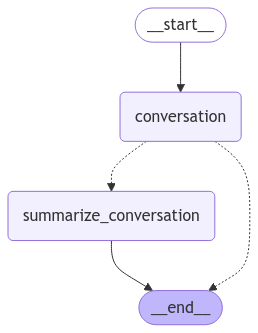

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState


model = ChatOpenAI(model="gpt-4o",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Recompile with SQLITE CHECKPOINTER
# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# now we call the grap several times
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke(
    {"messages": [input_message]}, 
    config
) 

for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I help you today?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a passionate fan base. Are you excited about their current season, or is there a particular player or moment from their history that you enjoy?


In [ ]:
# the state persists - it can load even after program restart
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='77b09ed5-3118-40a7-9321-8e6fe7e5549d'), AIMessage(content='Hello Lance! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 11, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'stop', 'logprobs': None}, id='run-ed56c9d1-0a54-48ae-bddf-24b0b12ae5e7-0', usage_metadata={'input_tokens': 11, 'output_tokens': 10, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata

## Streaming

We built a chat bot with external memory that can sustain long-running conversations.

To stream our graph state:

- We use `.stream` and `astream` are sync and async for streaming results.
  - We can do `values` : full state of graph after each node is called or 
  - `updates`: state of graph after each node is called

![values_vs_updates.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbaf892d24625a201744e5_streaming1.png)

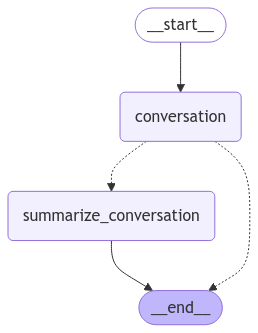

In [79]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

# State 
class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State, config: RunnableConfig):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages, config)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Values

In [84]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello Lance! How can I assist you today?
---------------------------------------------------------------------------


## Updates

In [85]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Lance! How's it going? If there's anything you'd like to talk about or need help with, feel free to let me know!


Often we want to stream further info e.g token size etc. We can use `.astream_events`: this streams back events as they happen inside the nodes

- Each event is a dict with a few keys:
    - `event`: type of event is emitted
    - `name`: name of event
    - `data`: data associated with the event
    - `metadata`: contains `langgraph_node` that is emitting the event

## Stream info on the whole graph

In [86]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: 

## Stream results from a node

In [87]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-cdfcabcb-942a-4db4-970c-a601f2a222d3')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run-cdfcabcb-942a-4db4-970c-a601f2a222d3')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run-cdfcabcb-942a-4db4-970c-a601f2a222d3')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run-cdfcabcb-942a-4db4-970c-a601f2a222d3')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run-cdfcabcb-942a-4db4-970c-a601f2a222d3')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run-cdfcabcb-942a-4db4-970c-a601f2a222d3')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run-cdfcabcb-942a-4db4-970c-a601f2a222d3')}
{'chunk': AIMessageChunk(content=' are', additional_kwargs={}, response_me

## By AI Message chunk

In [88]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| American| football| team| based| in| the| San| Francisco| Bay| Area|.| They| compete| in| the| National| Football| League| (|NFL|)| as| a| member| of| the| league|'s| National| Football| Conference| (|N|FC|)| West| division|.| The| team| was| founded| in| |194|6| as| a| charter| member| of| the| All|-Amer|ica| Football| Conference| (|AA|FC|)| and| joined| the| NFL| in| |194|9| when| the| leagues| merged|.

|###| Key| Points| about| the| |49|ers|:

|-| **|St|adium|**|:| The| |49|ers| play| their| home| games| at| Levi|'s| Stadium| in| Santa| Clara|,| California|,| which| they| moved| to| in| |201|4|.| Before| that|,| they| played| at| Cand|lestick| Park| in| San| Francisco|.

|-| **|Team| Colors|**|:| The| team's| colors| are| red|,| gold|,| and| white|.

|-| **|Champ|ionship|s|**|:| The| |49|ers| have| won| five| Super| Bowl| titles| (|X|VI|,| XIX|,| XX|III|,| XX|IV|,| and| XX|IX|),| with| their| most| successful| period| being| the|

## LangGraph API - Access Event Data

In [91]:
from langgraph_sdk import get_client

# Replace this with the URL of your own deployed graph
URL = "http://localhost:56440"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [95]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="chatbot", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1efa9de6-d48c-6add-ac38-65ab0de8d523', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '628f4f8e-2427-4f81-9539-28c961f4f4e4', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '628f4f8e-2427-4f81-9539-28c961f4f4e4', 'example': False}, {'content': '2 multiplied by 3 equals 6.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 9, 'prompt_tokens': 13, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens

In [96]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], assistant_id="chatbot", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'example': False} response_metadata={} id='33e2f8ff-25fb-4c86-b386-42e20241ce46'
content='2 multiplied by 3 equals 6.' additional_kwargs={'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 9, 'prompt_tokens': 13, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_831e067d82', 'finish_reason': 'stop', 'logprobs': None}, 'example': False, 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 13, 'output_tokens': 9, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}} r

In [98]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="chatbot", 
                                      input={"messages": [input_message]}, 
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


In [100]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="chatbot",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial": 
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 1efa9de9-680c-6d06-b412-2c378a5ab23a
--------------------------------------------------
--------------------------------------------------
AI: 2
--------------------------------------------------
AI: 2 multiplied
--------------------------------------------------
AI: 2 multiplied by
--------------------------------------------------
AI: 2 multiplied by 
--------------------------------------------------
AI: 2 multiplied by 3
--------------------------------------------------
AI: 2 multiplied by 3 equals
--------------------------------------------------
AI: 2 multiplied by 3 equals 
--------------------------------------------------
AI: 2 multiplied by 3 equals 6
--------------------------------------------------
AI: 2 multiplied by 3 equals 6.
--------------------------------------------------
AI: 2 multiplied by 3 equals 6.
Response Metadata: Finish Reason - stop
--------------------------------------------------


## Breakpoints {Human in the Loop}

- `Approval`: interrupt agent state, allow user to accept action.
- `Debugging`: can rewind the graph to reproduce issues.
- `Editing`: modify the state


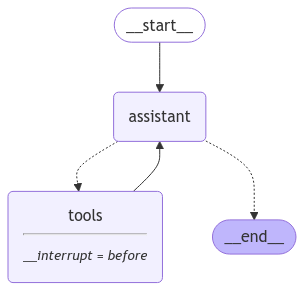

In [101]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [102]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_2XpgAWHFwT5KUvEJ73gZFaOO)
 Call ID: call_2XpgAWHFwT5KUvEJ73gZFaOO
  Args:
    a: 2
    b: 3


In [ ]:
state = graph.get_state(thread)
state.next

# if we invoke the graph with None: it will continue from the last checkpoint
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_2XpgAWHFwT5KUvEJ73gZFaOO)
 Call ID: call_2XpgAWHFwT5KUvEJ73gZFaOO
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


### Accepting User Input

In [105]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QR7rWZU5B4R9BV73cFg0K4tO)
 Call ID: call_QR7rWZU5B4R9BV73cFg0K4tO
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QR7rWZU5B4R9BV73cFg0K4tO)
 Call ID: call_QR7rWZU5B4R9BV73cFg0K4tO
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## LangGraph API Breakpoints

- Let's load the `agent` into LangGraph.
- In the python we can use `interrupt_before=['node']` when compiling the graph to Studio.
- But in the Studio API you can pass interrupt_before method also directly.


In [116]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:56623")

In [117]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'c162cb13-8c4a-439c-9086-93cc3d0cbf78', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_LUtC5s44KdYCt71VFXLHsIkH', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-

In [ ]:
# Now lets proceed from the breakpoint with input as None
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_LUtC5s44KdYCt71VFXLHsIkH', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-cf63f9ef-9cab-49ef-ae6f-561e0dc59cb9-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_LUtC5s44KdYCt71VFXLHsIkH', 'type': 'tool_call'}], 'invalid_tool_

## Actually Edit State during Interrupts



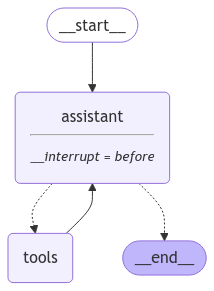

In [119]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [120]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [121]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='8b4e1694-8751-4089-bc1a-5c1726b150e5')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9e1b-2bef-66a2-8000-f738150b8823'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2024-11-23T21:27:10.336976+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9e1b-2bed-6546-bfff-af4e4f368a18'}}, tasks=(PregelTask(id='878518ee-1ef5-e877-a0cc-d8f375a5a94b', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))


**IF we want to overwrite a message, we can supply a message id**
- If we merely want to append a message, we can leave the id blank.

In [ ]:
# call graph update 
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa9e1e-cc08-62bc-8001-84eeca94d3f7'}}

In [ ]:
# since we already updated state, let it proceed from the breakpoint with input None...
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Q0luZy25e1ZvBQatepTIwgOI)
 Call ID: call_Q0luZy25e1ZvBQatepTIwgOI
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


After the tool call, we are back at the assitant which has a breakpoint.

In [125]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 and 3 is 9.


## Modfiying State in LangGraph API



In [148]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:56623")

initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'e2a3efa5-7ab4-4793-83c8-5152b5319eaa', 'example': False}
--------------------------------------------------


In [149]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'e2a3efa5-7ab4-4793-83c8-5152b5319eaa',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '4e8fa4b7-49d7-1821-bd33-8ec9e04ad1aa',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'step': 0,
  'run_id': '1efa9e31-08d6-6579-a6b9-7535d919e608',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': 'd461198f-2c74-4764-bf48-13f0619ce242',
  'created_by': 'system',
  'run_attempt': 1,
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'langgraph_host': 'self-hosted',
  'langgraph_plan': 'developer',
  'langgraph_version': '0.2.53'},
 'created_at': '2024-11-23T21:36:57.322968+00:00',
 'checkpoint': {'checkpoint_id': '1ef

In [150]:
# last message is
last_message = current_state['values']['messages'][-1]
last_message

# overwrite last message is ==
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': 'e2a3efa5-7ab4-4793-83c8-5152b5319eaa',
 'example': False}

In [151]:
# update graph state
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': 'd461198f-2c74-4764-bf48-13f0619ce242',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa9e31-88a1-6387-8001-6633f86a5e06'},
 'configurable': {'thread_id': 'd461198f-2c74-4764-bf48-13f0619ce242',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa9e31-88a1-6387-8001-6633f86a5e06'},
 'checkpoint_id': '1efa9e31-88a1-6387-8001-6633f86a5e06'}

In [152]:
# finally we resume the execution by passing input None
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'e2a3efa5-7ab4-4793-83c8-5152b5319eaa', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_Rr6PXp15RIdlY1tB7BQfC7Yp', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 138, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name':

## Awaiting User Input

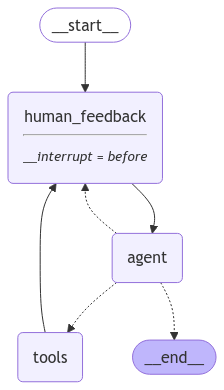

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode


# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def agent(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)
tools = [add, multiply, divide]


# Define nodes: these do the work
builder.add_node("agent", agent)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "agent")
builder.add_conditional_edges(
    "agent",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

2 * 3 and then divide by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zfjsSksgX5U92ktyn3wknq4y)
 Call ID: call_zfjsSksgX5U92ktyn3wknq4y
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [27]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================
Tool Calls:
  divide (call_v13KARS8YufItmGHIxLN4UC4)
 Call ID: call_v13KARS8YufItmGHIxLN4UC4
  Args:
    a: 6
    b: 10
================================= Tool Message =================================
Name: divide

0.6


In [184]:
for i in graph.get_state(thread).values['messages']:
    i.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================


================================== Ai Message ==================================
Tool Calls:
  multiply (call_OUSdDxhLSdxVZwzERR6s64fa)
 Call ID: call_OUSdDxhLSdxVZwzERR6s64fa
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

3 x 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_jgtoMXqjEqy9ME7T1pZRtdXu)
 Call ID: call_jgtoMXqjEqy9ME7T1pZRtdXu
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12
============================

## Time Travel LangGraph

- `View`
- `Replay`
- `Fork`



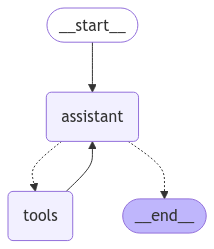

In [185]:
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [186]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_tlO4tDPGvNYr7Lo7lbR8IkS7)
 Call ID: call_tlO4tDPGvNYr7Lo7lbR8IkS7
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

- we can use `get_state` to get the state at a specific point in time with the `thread_id`:

In [190]:
graph.get_state({'configurable': {'thread_id': '1'}}).values['messages']

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9906e467-972a-42eb-a47d-d1cdf269ebfc'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tlO4tDPGvNYr7Lo7lbR8IkS7', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b0f0d508-7271-4cd2-9f45-73066fe0bce3-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_tlO4tDPGvNYr7Lo7lbR8IkS7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 17, 'total_t

Brose history of agent 

In [192]:
all_states = [s for s in graph.get_state_history(thread)]
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9906e467-972a-42eb-a47d-d1cdf269ebfc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tlO4tDPGvNYr7Lo7lbR8IkS7', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 131, 'total_tokens': 148, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b0f0d508-7271-4cd2-9f45-73066fe0bce3-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_tlO4tDPGvNYr7Lo7lbR8IkS7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 

In [193]:
len(all_states)

5

## Replay

We can re-run our agent from prior steps

In [194]:
to_replay = all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9906e467-972a-42eb-a47d-d1cdf269ebfc')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9ecf-aa66-6e18-8000-6be1d17f7561'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '1', 'step': 0, 'parents': {}}, created_at='2024-11-23T22:47:55.436179+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9ecf-aa64-6122-bfff-e3b43be91160'}}, tasks=(PregelTask(id='7a4cff95-ca14-40db-bef7-76f708d69dba', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tlO4tDPGvNYr7Lo7lbR8IkS7', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_t

In [197]:
print(to_replay.values)
print(to_replay.next)

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='9906e467-972a-42eb-a47d-d1cdf269ebfc')]}
('assistant',)


In [198]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa9ecf-aa66-6e18-8000-6be1d17f7561'}}

In [199]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_4Kwhpk1X9b2GYeOVZ0CKQdFX)
 Call ID: call_4Kwhpk1X9b2GYeOVZ0CKQdFX
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Forking

We want to run from the same step but with different input.

In [200]:
to_fork = all_states[-2]
to_fork.values["messages"]
print(to_fork.config)
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3', 
                               id=to_fork.values["messages"][0].id)]},
)

print(fork_config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9ecf-aa66-6e18-8000-6be1d17f7561'}}
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9ed9-61b2-6dc0-8001-9d748dee654e'}}


In [202]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='9906e467-972a-42eb-a47d-d1cdf269ebfc')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9ed9-61b2-6dc0-8001-9d748dee654e'}}, metadata={'source': 'update', 'writes': {'__start__': {'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='9906e467-972a-42eb-a47d-d1cdf269ebfc')]}}, 'thread_id': '1', 'step': 1, 'parents': {}, 'checkpoint_ns': '', 'checkpoint_id': '1efa9ecf-aa66-6e18-8000-6be1d17f7561'}, created_at='2024-11-23T22:52:16.248151+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa9ecf-aa66-6e18-8000-6be1d17f7561'}}, tasks=(PregelTask(id='bea55065-a4fd-4307-f922-c4d56682f8ce', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),))

In [203]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dqQynm849PPlR5abDBsfemdR)
 Call ID: call_dqQynm849PPlR5abDBsfemdR
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


## Time Travel with Langraph API

from langgraph_sdk import get_client
client = get_client(url="http://localhost:57753")

In [208]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:57753")

In [211]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_QyiQNAzTc4YVG2z4QtftLMk7', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-da3d0f18-04dc-4236-989f-b254e08e7e47-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_QyiQNAzTc4YVG2z4QtftLMk7', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'to

In [212]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1efa9ee1-f418-6e7c-9f25-17ea9652a66f', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'f87cf304-2737-4664-82e1-0f18463687cb', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'f87cf304-2737-4664-82e1-0f18463687cb', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_NVrVP5JdrlhMSfJqKkuheGtN', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_toke

## Forking


In [213]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_nQ9okP0WuBnhIOqcScBxtlkm', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-28ee1d1b-6bd4-45eb-8046-954376c5d84c-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_nQ9okP0WuBnhIOqcScBxtlkm', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'to

In [214]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '78c5c070-76e4-4f84-a308-3add6090404f',
   'example': False}]}

In [216]:
# edit the state
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)
states = await client.threads.get_history(thread['thread_id'])
states[0]


async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_ULlniQvt8VgQ1HrTNw3P7QfY', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_7f6be3efb0', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-844076c5-f459-4b41-8ce1-24e9f7ae61fe-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_ULlniQvt8VgQ1HrTNw3P7QfY', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'to

## Multi-Agent Parallelisation

### Sequential

In [217]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

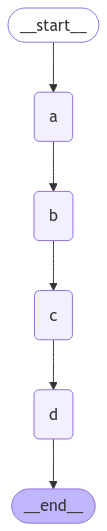

In [218]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [219]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

The state is overwritten by the last node.

## Parallel

Let's run b and c in parallel. And then d.

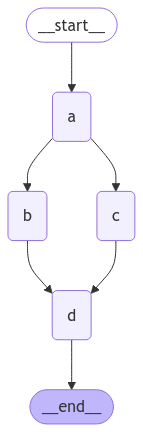

In [220]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [221]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


The error means they are writing to the same state key channel in the same step. We must use a reducer.



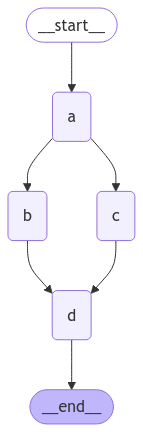

In [249]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [250]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

Let's examine when a parallel path has more steps takes longer than the other one:

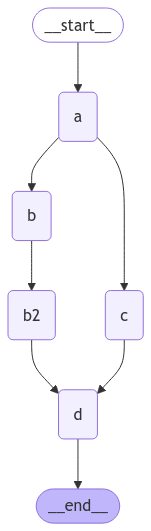

In [251]:
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [252]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

The graph waits for all to be completed before moving on to node `d`. However notice that `c` is added before `B2` without our control. 

To control we could e.g sort them alphabetically.

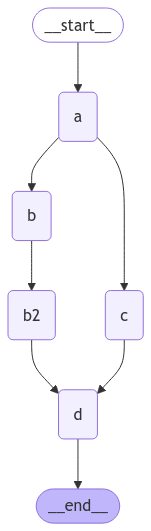

In [253]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]
    
    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [254]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

## Working with LLMs

- `WebSearch` with `Tavily`
- `Search` with `Wikipedia`
- 

In [256]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

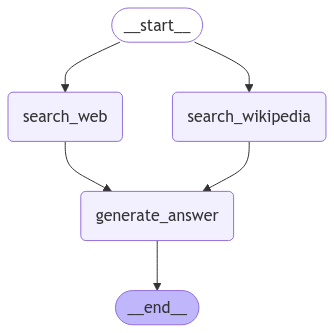

In [257]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools import TavilySearchResults

def search_web(state):
    
    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state):
    
    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def generate_answer(state):
    
    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question, 
                                                       context=context)    
    
    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
      
    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret 
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [258]:
result = graph.invoke({"question": "How were Nvidia's Q2 2024 earnings"})
result['answer'].content

"Nvidia's Q2 2024 earnings were exceptionally strong, driven primarily by its data center business. The company reported $10.32 billion in data center revenue, which was up 171% year over year. This growth was fueled by the demand for AI chips, such as the A100 and H100, which are essential for building and running AI applications like ChatGPT. Additionally, Nvidia's gaming division saw a revenue increase of 22% from the previous year, reaching $2.49 billion. Overall, Nvidia's performance in Q2 2024 was marked by significant growth and high demand for its products, particularly in the data center segment."

### LangGraph API Wiki



In [259]:
from langgraph_sdk import get_client
client = get_client(url="http://localhost:58211")

In [260]:
thread = await client.threads.create()
input_question = {"question": "How were Nvidia Q2 2024 earnings?"}
async for event in client.runs.stream(thread["thread_id"], 
                                      assistant_id="parallelization", 
                                      input=input_question, 
                                      stream_mode="values"):
    # Check if answer has been added to state  
    answer = event.data.get('answer', None)
    if answer:
        print(answer['content'])

Nvidia's Q2 2024 earnings were impressive, with the company reporting adjusted earnings per share of $0.68 on revenue of $30 billion, which was a record and up 122% over the same period last year. This exceeded Wall Street's expectations of $28.72 billion in revenue and earnings of $0.65 a share. The data center business was a significant contributor, bringing in $26.3 billion, surpassing expectations of $25 billion. The gaming division also saw a 16% year-over-year increase in revenue, reaching $2.8 billion. Despite these strong results, Nvidia's stock slipped slightly following the earnings report.


## Map Reducer

- Break tasks into subtasks and run them in parallel: create jokes.
- Reduce - combine the results of the subtask: select the best joke.



The state has `jokes` key which accumulates from parallelized joke generation.

The magic is we use `Send` : allows to pass any state key to `generate_topics`. 

In [ ]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    """
    Reducer to parallelize the generation of jokes for each subject.
    """
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

In [283]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

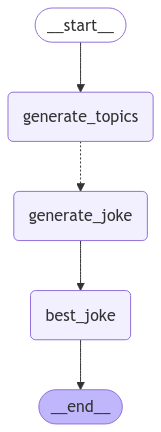

In [ ]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
# KEY ! 
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])

graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [285]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['mammals', 'reptiles', 'birds']}}
{'generate_joke': {'jokes': ["Why do seagulls fly over the ocean? Because if they flew over the bay, they'd be bagels!"]}}
{'generate_joke': {'jokes': ["Why don't scientists trust atoms when it comes to mammals? Because they make up everything, including the fur!"]}}
{'generate_joke': {'jokes': ["Why don't reptiles ever get lost? Because they always follow the 'scale' of the map!"]}}
{'best_joke': {'best_selected_joke': "Why do seagulls fly over the ocean? Because if they flew over the bay, they'd be bagels!"}}


## Subgraph 

Create and manage different states in different parts of a graph.

Useful in multi-agent scenarios, with teams of agents that each have their own state.

Example:

- System that accepts logs
- Performs two seperate substaks by different agents (summarize logs, find failure modes)
- perform these two operations in two different subgraphs
  
The communication is done with **overlapping keys**.


/var/folders/l0/5jp_3cl56t51wy399_v224h80000gn/T/ipykernel_1119/3394808583.py:41: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)


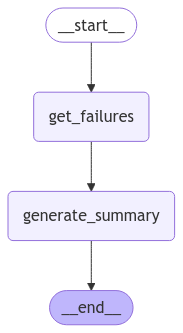

In [ ]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

# 1.________Failure Analysis Graph____________
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {
        "failures": failures
    }

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {
        "fa_summary": fa_summary, 
        "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]
    }

fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

/var/folders/l0/5jp_3cl56t51wy399_v224h80000gn/T/ipykernel_1119/4260390202.py:24: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)


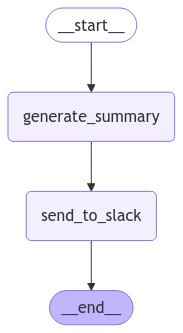

In [287]:
#______2. Summarization subgraph___________
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Now we must add the subgraph as NODES to the main graph.

- Create parent graph with `EntryGraphState`.

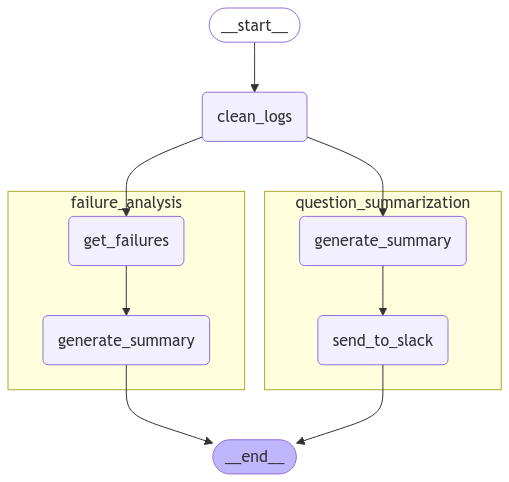

In [289]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [290]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

## Research Assistant

- `Memory`
- `Human in the Loop`
- `Controllability`

One of the most popular app. Research automation. Laborious work offloaded to analysts. Raw LLM outputs poorly suited for real world decision making workflows.

### Goal


Lightweight multi agent system around chat models that customizes research process.

- `Source Selection`: can choose any set of input sources for their research
- `Planning`: provide topic, system generates a team of AI analysts focusing on each sub-topic.
  - `Human-in-the-loop`: used to define topics before research begins.
- `LLM utilization`: each analyst will conduct in-depth interviews with AI using selected sources.
  - The interview will be multi-turn conversation. 
  - These interviews will be done in subgraphs with internal state.

- `Research Process`: Experts will gather questions in parallel and the interviews will be done simultaneously using `map-reduce`
- `Output Format`: gathered insights from each interview will be synthesized into a final report. 

In [291]:
from langchain_openai import ChatOpenAI
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"

llm = ChatOpenAI(model="gpt-4o", temperature=0) 

from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

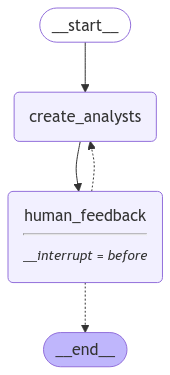

In [292]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback, 
        max_analysts=max_analysts
    )

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [293]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits and challenges of adopting new technologies like LangGraph. Her primary concern is how these technologies can drive innovation and efficiency within organizations. She is motivated by the potential for LangGraph to streamline processes and enhance productivity.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Data Security Analyst
Description: Mr. Patel is dedicated to understanding the security implications of adopting new frameworks such as LangGraph. His focus is on ensuring that the integration of such technologies does not compromise data integrity or privacy. He is motivated by the need to maintain robust security standards while embracing technological advancements.
--------------------------------------------------
Name: Dr. Lisa Nguyen
Affiliation: AI Ethics Conso

In [294]:
# Get state and look at next node
state = graph.get_state(thread)
state.next


('human_feedback',)

In [295]:
# We now update the state as if we are the human_feedback node
graph.update_state(
    thread, 
    {"human_analyst_feedback": "Add in someone from a startup to add an entrepreneur perspective"}, 
    as_node="human_feedback"
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efaa667-27ed-63e8-8002-cf99cd34a55c'}}

In [296]:
# continue the graph execution
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits and challenges of adopting new technologies like LangGraph. Her primary concern is how these technologies can drive innovation and efficiency within organizations. She is motivated by the potential for LangGraph to streamline processes and enhance productivity.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Data Security Analyst
Description: Mr. Patel is dedicated to understanding the security implications of adopting new frameworks such as LangGraph. His focus is on ensuring that the integration of such technologies does not compromise data integrity or privacy. He is motivated by the need to maintain robust security standards while embracing technological advancements.
--------------------------------------------------
Name: Dr. Lisa Nguyen
Affiliation: AI Ethics Conso

In [297]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(
    thread, 
    {"human_analyst_feedback": further_feedack}, 
    as_node="human_feedback"
)
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [300]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
final_state.next

()

In [299]:
analysts

[Analyst(affiliation='Tech Startup', name='Alex Johnson', role='Entrepreneur', description='Alex is a co-founder of a tech startup that specializes in AI-driven solutions. He is focused on the practical applications and scalability of LangGraph as an agent framework, particularly how it can be leveraged to accelerate product development and innovation in a startup environment.'),
 Analyst(affiliation='University of Technology', name='Dr. Emily Chen', role='Academic Researcher', description='Dr. Chen is a professor of computer science with a focus on agent-based systems. Her interest lies in the theoretical benefits of LangGraph, such as its potential to enhance the efficiency and effectiveness of multi-agent systems in academic research and complex simulations.'),
 Analyst(affiliation='Global Tech Corporation', name='Michael Thompson', role='Industry Expert', description='Michael is a senior software engineer at a leading global tech company. He is interested in the integration of Lang

In [ ]:
### 

### Conduct Interview



In [302]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

The expert will gather information from multiple sources in parallel to answer questions:

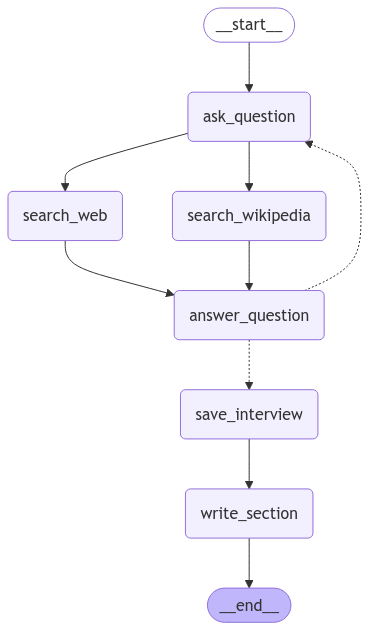

In [303]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [304]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Startup', name='Alex Johnson', role='Entrepreneur', description='Alex is a co-founder of a tech startup that specializes in AI-driven solutions. He is focused on the practical applications and scalability of LangGraph as an agent framework, particularly how it can be leveraged to accelerate product development and innovation in a startup environment.')

In [305]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0]) 

## Accelerating AI Innovation in Startups with LangGraph

### Summary

In the rapidly evolving landscape of AI-driven solutions, startups are constantly seeking frameworks that can streamline development processes and enhance scalability. LangGraph emerges as a pivotal tool in this context, offering a robust agent framework that simplifies the creation and management of AI applications. This report delves into the practical applications and scalability of LangGraph, highlighting its potential to accelerate product development and innovation in a startup environment.

LangGraph is designed to abstract the complexities associated with state management and agent coordination, allowing developers to focus on defining workflows and logic without being bogged down by underlying mechanisms [1]. This abstraction is particularly beneficial for startups, where resources are often limited, and the need for rapid development cycles is critical. By supporting diverse control flows—such as single agent, multi-agent, hierarchical, and sequential—LangGraph can handle complex scenarios that are common in both startups and established enterprises [2].

One of the most novel aspects of LangGraph is its integration into the LangChain ecosystem, which provides access to a wide array of integrations and observability tools. This integration not only enhances the functionality of LangGraph but also ensures that developers can leverage existing tools and frameworks to build more sophisticated applications [3]. The flexibility of LangGraph makes it well-suited for interactive AI systems, enabling more adaptable and customizable agent runtimes [4].

The potential of LangGraph in enabling the development of industry-specific AI applications is significant. By organizing AI agents and their interactions through a graph-based approach, LangGraph allows for the creation of more intelligent and responsive applications. This capability is crucial for startups aiming to innovate and differentiate themselves in a competitive market [5].

In summary, LangGraph offers a scalable and flexible framework that can significantly accelerate AI product development in startups. Its ability to simplify complex processes and integrate seamlessly with existing ecosystems makes it an invaluable tool for fostering innovation and driving growth in the tech startup sector.

### Sources
[1] https://www.datacamp.com/tutorial/langgraph-tutorial  
[2] https://www.langchain.com/langgraph  
[3] https://blog.langchain.dev/langgraph-multi-agent-workflows/  
[4] https://www.ampcome.com/articles/what-is-langgraph-how-it-is-useful-in-building-llm-based-applications  
[5] https://www.gettingstarted.ai/langgraph-tutorial-with-example/  

## Parallel Interviews `Map-Reduce`


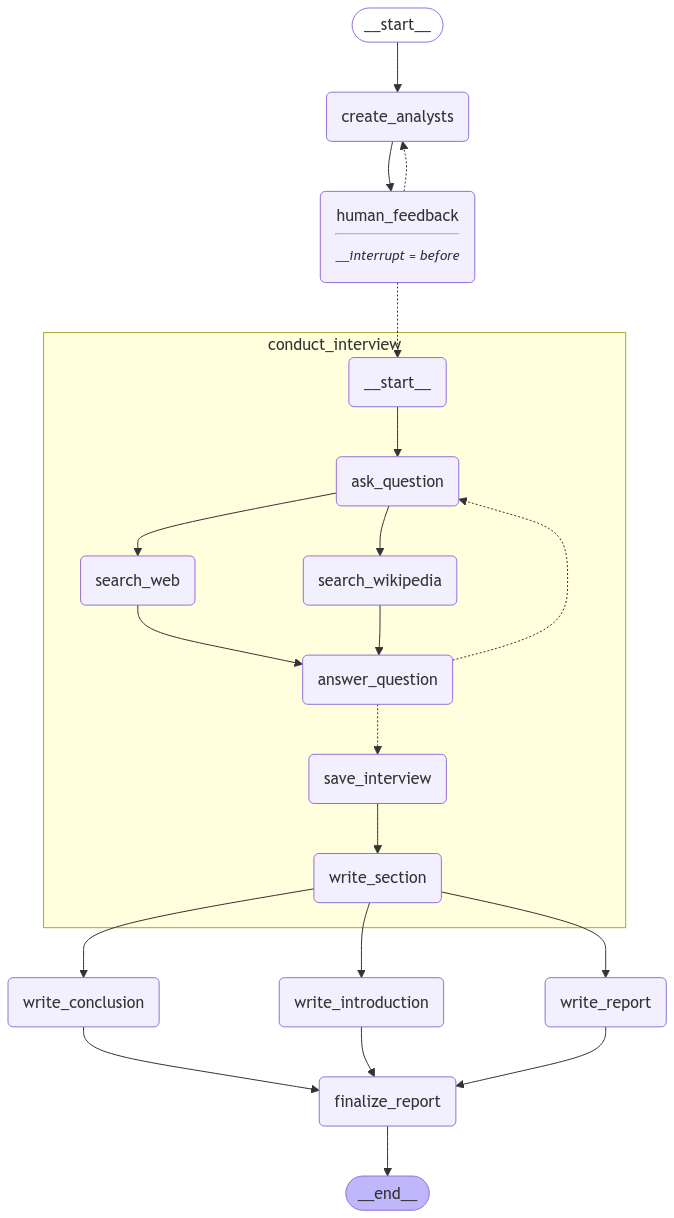

In [306]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report
    
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [308]:
# Inputs
max_analysts = 3 
topic = "The top job boards for AI engineers 2024 europe"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovators Inc.
Role: Technology Adoption Specialist
Description: Dr. Carter focuses on the strategic benefits and challenges of adopting new technologies like LangGraph. She is particularly interested in how these frameworks can enhance operational efficiency and drive innovation within organizations.
--------------------------------------------------
Name: Mr. Raj Patel
Affiliation: Data Security Solutions
Role: Data Security Analyst
Description: Mr. Patel is concerned with the security implications of adopting new frameworks such as LangGraph. His analysis centers on identifying potential vulnerabilities and ensuring that data integrity and privacy are maintained during and after the adoption process.
--------------------------------------------------
Name: Ms. Linda Zhao
Affiliation: GreenTech Enterprises
Role: Sustainability Consultant
Description: Ms. Zhao examines the environmental impact and sustainability benefits of adopting LangGraph.

In [309]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efaa67a-ce50-657e-8005-4597d86a877b'}}

In [310]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Clara Jensen
Affiliation: European Institute of Technology
Role: AI Job Market Researcher
Description: Dr. Jensen focuses on analyzing trends in the AI job market across Europe. Her primary concern is understanding how job boards are evolving to meet the needs of AI engineers and how these platforms can better serve both job seekers and employers. She is motivated by the desire to improve the efficiency and effectiveness of job matching in the AI sector.
--------------------------------------------------
Name: Mr. Liam O'Connor
Affiliation: Tech Recruitment Solutions
Role: Recruitment Strategist
Description: Mr. O'Connor specializes in developing strategies for tech recruitment, with a focus on AI roles. His concerns include the accessibility and user-friendliness of job boards for AI engineers, as well as the integration of advanced technologies like AI and machine learning in recruitment processes. He aims to enhance the recruitment experience for both candidates and compan

In [311]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efaa67b-9c30-6b24-8007-22a08863b600'}}

In [312]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [313]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Top Job Boards for AI Engineers 2024: Europe

## Introduction

As the AI job market in Europe undergoes rapid transformation, driven by technological advancements and substantial investments, the demand for skilled AI engineers is surging. This report explores the evolving landscape, highlighting key trends and opportunities for job seekers and employers alike. We delve into the strategic investments by European governments, such as Germany's "AI Made in Germany" initiative, and their impact on job availability in major cities. Additionally, we examine the role of job boards like Wellfound and Jooble in connecting AI talent with startups and established companies, emphasizing the importance of continual upskilling in this dynamic field.

---



The AI job market in Europe is experiencing significant growth, driven by technological advancements and substantial investments in artificial intelligence. European governments, particularly Germany, are heavily investing in AI research and development, with initiatives like "AI Made in Germany" aiming to establish the country as a global leader in AI innovation [1][2]. This investment is mirrored in the job market, with a high demand for AI specialists in cities such as Berlin, Munich, and Stuttgart, where AI applications are expanding into sectors like sustainable energy and smart cities [1][2].

Job boards play a crucial role in this evolving landscape, providing platforms for AI engineers and startups to connect efficiently. Wellfound is particularly popular among AI engineers, offering a streamlined application process that allows candidates to apply to multiple positions with a single profile [2][3]. This platform, along with others like OpenCV and Jooble, facilitates direct access to hiring managers and quick response times from companies such as Nolana AI and Xenara AI, enhancing the job-seeking experience [1][3].

The diversity of roles in the AI sector is expanding, with specialized positions such as Generative AI Engineer, AI Cybersecurity Solutions Engineer, and AI/ML Integration Engineer gaining prominence [3]. This diversification reflects the growing complexity within the AI field, necessitating continuous upskilling for professionals to remain competitive [1]. Moreover, AI is increasingly seen as a catalyst for job creation rather than a threat, with startups leveraging AI to enhance operations and expand their workforce [4].

For AI startups, job boards are not merely tools for filling vacancies but strategic resources for building innovative teams. These platforms enable startups to navigate the competitive job market effectively, attract top talent, and position themselves for success in the AI industry [5]. The European Commission's strategic initiatives further support this ecosystem by providing startups with access to essential resources like data and computing power [5].

In summary, the European AI job market offers a dynamic and promising landscape for both AI engineers and startups. The combination of government support, innovative job platforms, and a diverse range of roles presents numerous opportunities for growth and development in this rapidly evolving sector.


---

## Conclusion

The European AI job market is a dynamic and rapidly evolving landscape, offering a wealth of opportunities for both job seekers and employers. This report has highlighted the significant trends and opportunities within this market, emphasizing the role of government investment, particularly in Germany, in driving AI innovation and job creation. Platforms like Wellfound and Jooble have emerged as crucial tools for connecting AI engineers and startups with potential employers, streamlining the recruitment process. As the demand for specialized roles grows, continuous upskilling remains essential for professionals to stay competitive. By leveraging these insights and resources, stakeholders can effectively navigate and thrive in the burgeoning AI sector.

## Sources
[1] https://opencv.org/blog/ai-jobs-in-europe/  
[2] https://wellfound.com/role/l/ai-engineer/europe  
[3] https://aicareers.jobs/job-location/europe/  
[4] https://toolhunt.io/europes-startups-see-ai-as-a-catalyst-for-hiring-not-job-cuts/  
[5] https://digital-strategy.ec.europa.eu/en/news/commission-launches-ai-innovation-package-support-artificial-intelligence-startups-and-sme